## Assignment 1

⚠️ **Important! Submission Requirements**

1. **Do NOT clear notebook logs or outputs.**  
   Every output cell must remain visible (e.g., print logs, progress logs, summary messages).

2. **The notebook must be *self-contained*.**  
   - You should be able to run it **from top to bottom once** without any manual steps.  
   - No need for any external scripts, config files, or multiple runs.
   - Creating multiple cells/blocks is OK.

3. **Single `.ipynb` implementation.**  
   Do not create separate Python files or folders other than the generated image output directory.

4. **Clean, readable, and well-commented code.**

5. **Submission file name format:**  
   → `studentID_name.zip`  
   (Example: `2025000000_jungbeomlee.zip`)
   - This file should contain `best.pth`, and `COSE-474-02-Assignment_1.ipynb`. DO NOT include `mnist_images` folder.
---


## Python familiarization
**🎯 Goal**

Warm up with Python and the PyTorch data ecosystem by:

1. Loading the **MNIST** dataset (train & test).  
2. Randomly splitting 10% of the training set into a validation set.  
3. Exporting the images to a folder structure on disk in the format `<split>/<class>/<zero_padded>.jpg`, e.g., `train/0/00000.jpg`, `val/1/00000.jpg`, `test/3/00000.jpg`.


**What you’ll practice**

1. Using `torchvision.datasets.MNIST` to download & access data  
2. Basic Python file I/O with `pathlib` / `os`  
3. Converting tensors/PIL images and saving to disk with `PIL`  
4. Performing a **manual dataset split** (train → train/val)  
5. Implementing **progress tracking and sanity checks**

**Dataset**

- MNIST consists of:
  - **60,000 training** images  
  - **10,000 test** images  
- Each image: 28×28 pixels, grayscale, labeled **0–9**.

**Your task**

1. **Download** both MNIST `train` and `test` datasets using `torchvision.datasets.MNIST`.  

2. **Split** the training dataset:
   - Randomly take **10% of the train samples** for **validation**.  
   - Do not use automatic random split libraries (e.g., `torch.utils.data.random_split()`). Try to manually implement the random splitting codes.
3. **Iterate** through the dataset and save each sample as a JPEG image into the corresponding split / class folder.
Example target layout:
```
mnist_images/
train/
0/
00000.jpg
00001.jpg
1/
00000.jpg
...
val/
0/
00000.jpg
...
test/
0/
00000.jpg
...
```
4. Use **zero-padded 5-digit filenames** for all images  
(e.g., `00000.jpg`, `00001.jpg`, …) so lexicographic order matches numeric order.
5. Keep the images **grayscale** (`mode='L'`) and save as `.jpg`

Train data: 60000
Test data: 10000
[After Split] Train data: 54000
[After Split] Val data: 6000
[Saved train] total=54000 per_class={0: 5335, 1: 6016, 2: 5378, 3: 5550, 4: 5209, 5: 4874, 6: 5352, 7: 5654, 8: 5287, 9: 5345}
[Saved val] total=6000 per_class={0: 588, 1: 726, 2: 580, 3: 581, 4: 633, 5: 547, 6: 566, 7: 611, 8: 564, 9: 604}
[Saved test] total=10000 per_class={0: 980, 1: 1135, 2: 1032, 3: 1010, 4: 982, 5: 892, 6: 958, 7: 1028, 8: 974, 9: 1009}


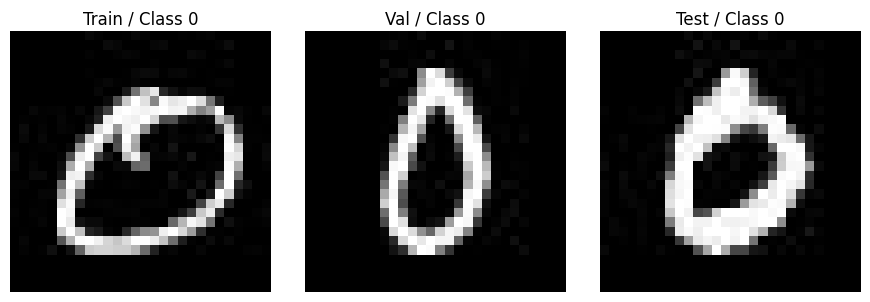

In [ ]:
# Implement your codes here!

from torchvision import datasets

train_dataset = datasets.MNIST(root="./data", train=True, download=True)
test_dataset  = datasets.MNIST(root="./data", train=False, download=True)

# data load test
print(f"Train data: {len(train_dataset)}")
print(f"Test data: {len(test_dataset)}")

# 수동 data split
def train_data_split(train_dataset, val_ratio=0.1, seed=42):
    import random

    # 재현 가능성 위한 추가
    random.seed(seed)

    # split 위한 전체 index list 생성
    total_size = len(train_dataset)
    indices = list(range(total_size))

    # random split 보장을 위해 임의로 idx를 섞는다.
    random.shuffle(indices)

    # 분할 기준점 계산
    num_val = int(total_size * val_ratio)
    train_indices = indices[num_val:]
    val_indices = indices[:num_val]

    # 섞은 data를 비율대로 나눈다.
    train_data = [train_dataset[i] for i in train_indices]
    val_data = [train_dataset[i] for i in val_indices]

    # spilt 후 data 크기
    print(f"[After Split] Train data: {len(train_data)}")
    print(f"[After Split] Val data: {len(val_data)}")

    return train_data, val_data

train_data, val_data = train_data_split(train_dataset, val_ratio=0.1, seed=42)

# data 저장
import os
from PIL import Image

## 헬퍼 함수
def make_dir(path: str):
    os.makedirs(path, exist_ok=True)
## 본 함수
def save_split_as_jpeg(split_data, split_name: str, out_root: str= "mnist_images"):
    """
    split_data: “저장할 데이터(이미지, 라벨 쌍)” 그 자체, [(PIL.Image, label), ...] 형태 (train_data/val_data/test_dataset)
    split_name: “train / val / test 중 어떤 세트인지” 표시용 이름, 'train' | 'val' | 'test'
    out_root:   최상위 출력 폴더
    규칙:
      - mnist_images/train/0/00000.jpg ...
      - 파일명 5자리 zero-padding, 그레이스케일 'L', .jpg
      - 각 클래스 폴더마다 00000부터 카운트 시작
    """
    from collections import defaultdict
    split_root = os.path.join(out_root, split_name)
    # 클래스 폴더 생성 및 클래스별 카운터 준비
    # 없는 키(label)가 들어오면 자동으로 0을 반환하도록 defaultdict 사용
    class_counters = defaultdict(int)
    for cls in range(10):
        make_dir(os.path.join(split_root, str(cls)))

    # 이미지 저장
    for img, label in split_data:
      # tensor -> PIL
      if not isinstance(img, Image.Image):
        img = Image.fromarray(img.numpy().squeeze())

      # gray scale 보장
      img = img.convert('L')

      idx_in_class = class_counters[label]
      # zero-padding
      filename = f"{idx_in_class:05d}.jpg"
      # 저장
      save_path = os.path.join(split_root, str(label), filename)
      img.save(save_path, format="JPEG")
      class_counters[label] += 1

    # 요약
    per_class_counts = {c: cnt for c, cnt in sorted(class_counters.items())}
    total = sum(per_class_counts.values())
    print(f"[Saved {split_name}] total={total} per_class={per_class_counts}")

# 저장 함수 호출
save_split_as_jpeg(train_data, "train", out_root="mnist_images")
save_split_as_jpeg(val_data,   "val",   out_root="mnist_images")

# test_dataset은 torch Dataset이므로 (img, label) 튜플로 순회 리스트를 생성
test_list = [test_dataset[i] for i in range(len(test_dataset))]
save_split_as_jpeg(test_list, "test", out_root="mnist_images")

import matplotlib.pyplot as plt
from PIL import Image

# 각 split에서 0번 클래스의 첫 번째 이미지 경로
img_path_train = "mnist_images/train/0/00000.jpg"
img_path_val = "mnist_images/val/0/00000.jpg"
img_path_test = "mnist_images/test/0/00000.jpg"

# 이미지 저장이 잘 되었는지 확인하기 위해 아무생각없이 했는데
# 아래 두번째 소문제에 포함되어 있었다...
# 이미지 불러오기
img_train = Image.open(img_path_train)
img_val = Image.open(img_path_val)
img_test = Image.open(img_path_test)

# 시각화
plt.figure(figsize=(9,3))

plt.subplot(1,3,1)
plt.imshow(img_train, cmap='gray')
plt.title("Train / Class 0")
plt.axis('off')

plt.subplot(1,3,2)
plt.imshow(img_val, cmap='gray')
plt.title("Val / Class 0")
plt.axis('off')

plt.subplot(1,3,3)
plt.imshow(img_test, cmap='gray')
plt.title("Test / Class 0")
plt.axis('off')

plt.tight_layout()
plt.show()

## PyTorch Custom DataLoader

**Objective**

PyTorch provides pre-defined data loaders for popular datasets (e.g., MNIST). However, in practice, you often need to create your own data loader. So, let's practice implementing a custom data loader!

Using the images you exported above (folder layout: `mnist_images/<split>/<class>/<00000.jpg>`), implement a **custom `torch.utils.data.Dataset`** and wrap it with **`DataLoader`** for training/validation/test.

**Requirements**

1. Assume the data directory structure above
2. Implement a dataset class that:
- Takes arguments `split` where `split` ∈ {'train', 'val', 'test'}
- Scans class folders (`0`–`9`) and builds `(filepath, label)` index
- Loads each image as **grayscale ('L')**
- Applies user-defined `transform`
- Returns `(image_tensor, label_int)`
3. Create `DataLoader`s with configurable:
- `batch_size`, `shuffle`, `num_workers`
- shuffle=True for train, False for val/test
4. Provide a **quick sanity check**:
- Print dataset size per split
- Fetch one batch with `batch_size=10` from 'train' and visualize each image and label with matplotlib

**Required transforms**
- To tensor: `ToTensor()` (→ shape `[1, H, W]`, values in `[0,1]`)
- Normalization: `Normalize(mean=[0.5], std=[0.5])`



Train dataset size: 54000
Val dataset size: 6000
Test dataset size: 10000


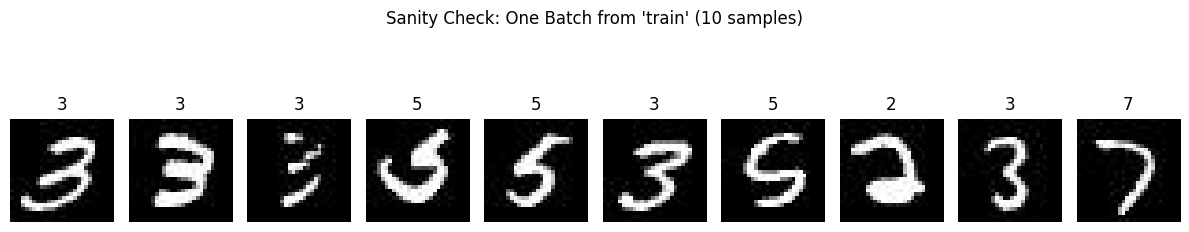

In [ ]:
# Implement your codes here!

import os
from PIL import Image
from pathlib import Path # Path는 문자열 기반 경로("mnist_images/train/0")를 객체 형태로 다루게 해주는 클래스

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt

root_dir = "mnist_images"
batch_size = 64 # Your own value
num_workers = 2 # Your own value
pin_memory = torch.cuda.is_available() # cuda 사용 가능 여부 확인

class MNISTFolderDataset(Dataset):
    def __init__(self, root: Path, split: str, transform=None):
        assert split in {"train", "val", "test"}, "split must be one of {'train', 'val', 'test'}"
        self.root = Path(root)
        self.split = split
        self.transform = transform

        split_root = self.root / split
        if not split_root.is_dir():
            raise ValueError(f"Invalid split directory: {split_root}")

        # (filepath, label) list 생성
        """
        [
        ("mnist_images/train/0/00000.jpg", 0),
        ("mnist_images/train/0/00001.jpg", 0),
        ("mnist_images/train/1/00000.jpg", 1),
        ...
        ]
        """
        self.samples = []
        for cls in range(10): # 데이터셋의 label이 0~9까지니까 range(10)
            cls_dir = split_root / str(cls)
            # 만약 폴더가 없을 경우 경고 메시지 출력
            if not cls_dir.is_dir():
                print(f"[WARN] class 폴더를 찾을 수 없습니다.: {cls_dir}")
                continue
            # 폴더 안의 모든 .jpg 파일 경로 가져오기
            for p in sorted(cls_dir.glob("*.jpg")):
                self.samples.append((str(p), int(cls))) # 각 이미지의 경로(p)와 라벨 번호(cls)를 튜플로 묶어서 저장
        # 혹시 데이터가 하나도 안 들어왔다면 (폴더가 비어있거나 경로 잘못 지정) 에러 발생
        if len(self.samples) == 0:
            raise RuntimeError(f"No samples found in {split_root}")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, label = self.samples[idx] # 데이터 하나 꺼내오기
        img = Image.open(path).convert("L") # 이미지 gray scale로 꺼내기
        if self.transform is not None: # Tensor로 변환 및 정규화
            img = self.transform(img)
        return img, label # 하나의 샘플 리턴

transform = transforms.Compose([
    # 이미지 tensor로 변환 및 정규화
    transforms.ToTensor(),  # [H, W] → [1, H, W] 텐서로 변환
    transforms.Normalize(mean=[0.5], std=[0.5])   # [0,1] → [-1,1]로 정규화
])

train_ds = MNISTFolderDataset(root_dir, "train", transform=transform)
val_ds   = MNISTFolderDataset(root_dir, "val",   transform=transform)
test_ds  = MNISTFolderDataset(root_dir, "test",  transform=transform)

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True,
                          num_workers=num_workers, pin_memory=pin_memory)
val_loader   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False,
                          num_workers=num_workers, pin_memory=pin_memory)
test_loader  = DataLoader(test_ds,  batch_size=batch_size, shuffle=False,
                          num_workers=num_workers, pin_memory=pin_memory)


# implement sanity check here
print(f"Train dataset size: {len(train_ds)}")
print(f"Val dataset size: {len(val_ds)}")
print(f"Test dataset size: {len(test_ds)}")

# recover the normalized images into the original space
def denorm(x):
    # x: tensor in [-1,1]
    return (x * 0.5) + 0.5  # -> [0,1]

# implement your code to visualize the actual samples using matplotlib using denorm function above
# Sanity check: train에서 10장 뽑아 시각화
vis_loader = DataLoader(train_ds, batch_size=10, shuffle=True,
                        num_workers=num_workers, pin_memory=pin_memory)
imgs, labels = next(iter(vis_loader))
imgs = denorm(imgs)  # 시각화용 복구

plt.figure(figsize=(12, 3))
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(imgs[i, 0].cpu(), cmap='gray')  # [B,1,H,W] -> [H,W]
    plt.title(int(labels[i]))
    plt.axis('off')
plt.suptitle("Sanity Check: One Batch from 'train' (10 samples)")
plt.tight_layout()
plt.show()

## Model Architecture

Design and implement a simple convolutional neural network for the MNIST dataset.
You are provided with a description of the architecture below, and your task is to implement the model class so that each layer’s output shape matches the description exactly.


**Model Description**

You may need to include appropriate activation functions in between.

0. input: (B, 1, 28, 28)
1. conv1: output (B, 32, 28, 28)
2. conv2: output (B, 64, 28, 28)
3. maxpool1: output (B, 64, 14, 14)
4. conv3: output (B, 128, 14, 14)
5. conv4: output (B, 128, 14, 14)
6. maxpool2: output (B, 128, 7, 7)
7. flatten: output (B, 128x7x7)
8. fc1: output (B, 256)
9. fc2: output (B, `n_class`)


**Requirements**
1. **Implement a model class** (`MyConvNet`).
- Use `nn.Conv2d`, `nn.ReLU`, `nn.MaxPool2d`, and `nn.Linear` layers.
- Adjust **`kernel_size` / `stride` / `padding`** so that each output shape matches the description above.
2. **Sanity check with zero input**  
- Create a zero tensor with shape **`[batch=10, channels=1, height=28, width=28]`** and run it through the model. Print the output shape.
3. Implementation Constraints
- Keep the architecture identical to the description.
- No BatchNorm or Dropout for this time.


In [ ]:
# Implement your codes here!

import torch
import torch.nn as nn

# 학습 진행을 위한 장치 선언
# 가능하다면 GPU 사용
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

class MyConvNet(nn.Module):
    def __init__(self, n_class=10):
        super().__init__()

        # Conv layers
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        # Fully connected layers
        self.fc1 = nn.Linear(128 * 7 * 7, 256)
        self.fc2 = nn.Linear(256, n_class)

        # Activation
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.conv1(x))   # (B,32,28,28)
        x = self.relu(self.conv2(x))   # (B,64,28,28)
        x = self.pool1(x)              # (B,64,14,14)
        x = self.relu(self.conv3(x))   # (B,128,14,14)
        x = self.relu(self.conv4(x))   # (B,128,14,14)
        x = self.pool2(x)              # (B,128,7,7)
        x = torch.flatten(x, 1)        # (B,128*7*7)
        x = self.relu(self.fc1(x))     # (B,256)
        x = self.fc2(x)                # (B,n_class)
        return x

# define your model here & do the sanity check
model = MyConvNet().to(device)
print(model)

# sanity check
dummy_input = torch.zeros((10, 1, 28, 28)).to(device)
output = model(dummy_input)
print(f"Output shape: {output.shape}")

Using device: cuda
MyConvNet(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=6272, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=10, bias=True)
  (relu): ReLU()
)
Output shape: torch.Size([10, 10])


## Training with GPUs

**Goal**

Train your `MyConvNet` using **SGD** with **momentum** and **weight decay**. For here, do not use `test` set yet.

**Requirements**

0. Use GPUs!
1. **Optimizer**: `torch.optim.SGD`  
- **Momentum**: must be used (non-zero)  
- **Weight Decay**: must be used (non-zero)
2. **Loss**: `nn.CrossEntropyLoss()`
3. **Logging**:
- Define `history` dictionary with the keys of "train_loss" and "val_acc".
- **Store**: `train_loss` (epoch-average) and `val_acc` (epoch) into lists for later plotting
4. **Early Stopping**:  
- Keep track of best `val_acc`  
- When `val_acc` improves against the historical best, **save** model weights to `best.pth`  
- If no improvement for `patience` epochs, **stop**
5. Once your training is done, you should have:
- Plot two figures, each of `history["train_loss"]` and `history["val_acc"]` with epochs.
- Saved `best.pth` containing the best-performing weights on validation

Using device: cuda
[Epoch 01] train_loss=0.3584 | val_acc=0.9810
New best! val_acc=0.9810 (saved to best.pth)
[Epoch 02] train_loss=0.0512 | val_acc=0.9843
New best! val_acc=0.9843 (saved to best.pth)
[Epoch 03] train_loss=0.0351 | val_acc=0.9865
New best! val_acc=0.9865 (saved to best.pth)
[Epoch 04] train_loss=0.0268 | val_acc=0.9863
[Epoch 05] train_loss=0.0201 | val_acc=0.9883
New best! val_acc=0.9883 (saved to best.pth)
[Epoch 06] train_loss=0.0150 | val_acc=0.9895
New best! val_acc=0.9895 (saved to best.pth)
[Epoch 07] train_loss=0.0131 | val_acc=0.9885
[Epoch 08] train_loss=0.0123 | val_acc=0.9907
New best! val_acc=0.9907 (saved to best.pth)
[Epoch 09] train_loss=0.0096 | val_acc=0.9902
[Epoch 10] train_loss=0.0082 | val_acc=0.9893
[Epoch 11] train_loss=0.0069 | val_acc=0.9912
New best! val_acc=0.9912 (saved to best.pth)
[Epoch 12] train_loss=0.0055 | val_acc=0.9900
[Epoch 13] train_loss=0.0060 | val_acc=0.9907
[Epoch 14] train_loss=0.0053 | val_acc=0.9910
[Epoch 15] train_loss=

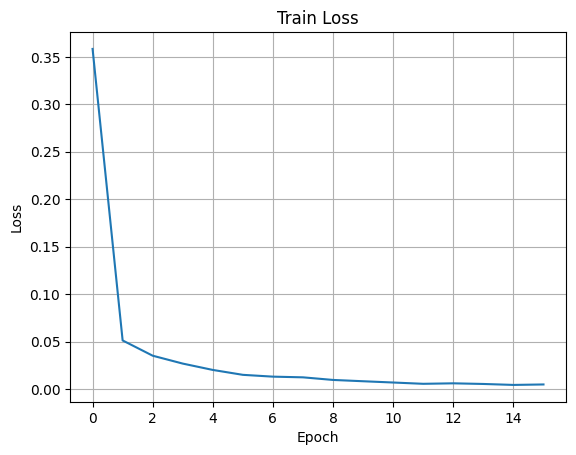

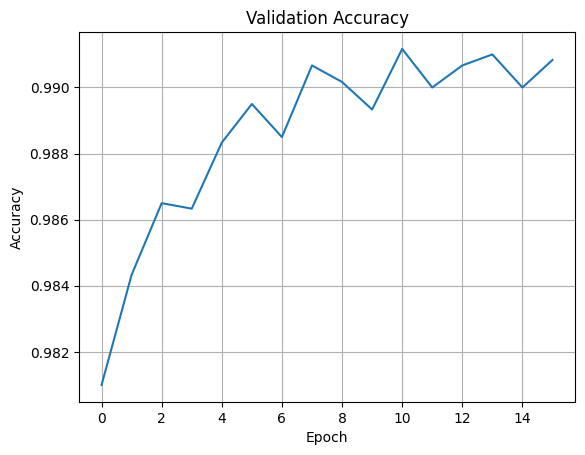

In [ ]:
# Implement your codes here!

import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from pathlib import Path

device = "cuda"
print("Using device:", device)

# define your hyper-parameters
max_epochs = 30
lr = 0.01 # learning rate
momentum = 0.9 # optimizer 관성
weight_decay = 5e-4 # L2 규제
patience = 5 # early stop 조건

# define your model, loss, and optimizer
model = MyConvNet(n_class=10).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr,
                      momentum=momentum, weight_decay=weight_decay)

# define history for logging
history = {
    "train_loss": [],
    "val_acc": [],
}

# 헬퍼 함수: val split에서 정확도 평가
@torch.no_grad()
def evaluate_acc(model, loader, device):
    model.eval()
    correct, total = 0,0 # 누적 정답 수 및 표본 수 카운터
    for imgs, labels in loader:
        imgs, labels = imgs.to(device), labels.to(device)
        logits = model(imgs) # [B, n_class]
        preds = logits.argmax(dim=1) # [B]
        correct += (preds == labels).sum().item() # 배치 내에서 예측과 정답이 같은 위치를 boolean 텐서로 만든 뒤, sum()으로 맞춘 개수를 합
        total += labels.size(0) # 배치 크기만큼 표본 수를 누적
    return correct / max(total, 1) # 혹시나 빈 loader 일 경우 0으로 나누는 에러 방지

# training
best_acc = 0.0
no_improve = 0

for epoch in range(1, max_epochs + 1):
    model.train()
    running_loss, n_batches = 0.0, 0 # 한 epoch 동안 loss 누적 후 평균 및 처리한 미니배치 개수

    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad() # 기울기 초기화
        logits = model(imgs) # [B, n_class], 순전파
        loss = criterion(logits, labels) # loss 계산
        loss.backward() # 역전파
        optimizer.step() # 가중치 업데이트

        running_loss += loss.item() # 현재 배치의 손실 누적
        n_batches += 1

    train_loss = running_loss / max(n_batches, 1) # 한 epoch 동안 평균 손실
    val_acc = evaluate_acc(model, val_loader, device)

    history["train_loss"].append(train_loss)
    history["val_acc"].append(val_acc)

    print(f"[Epoch {epoch:02d}] train_loss={train_loss:.4f} | val_acc={val_acc:.4f}")


    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), "best.pth")
        print(f"New best! val_acc={best_acc:.4f} (saved to best.pth)")
        no_improve = 0
    else:
        no_improve += 1
        if no_improve >= patience:
            print(f"Early stopping triggered (patience={patience})")
            break

print(f"Best validation accuracy: {best_acc:.4f}")

# plot training loss and validation accuracy by epochs
plt.figure()
plt.plot(history["train_loss"])
plt.title("Train Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

plt.figure()
plt.plot(history["val_acc"])
plt.title("Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True)
plt.show()


## Evaluation with Test Set

**Objective**

Load the best-performing model checkpoint (`best.pth`) saved during training above and evaluate it on the **test dataset** to measure the final **test accuracy**. For here, no retraining allowed — this block only loads and evaluates.

Your model must achieve **at least 99% test accuracy** on MNIST.  
If your test accuracy is **below 99%**, you are required to **revisit and iterate on your training block** by adjusting hyperparameters (e.g., learning rate, momentum, weight decay, batch size, or number of epochs) until the requirement is met.

**Requirements**

1. Model Loading
- Recreate the same model architecture (`MyConvNet`) as used for training.
- Load the trained weights:
     ```python
     model.load_state_dict(torch.load("best.pth", map_location=device))
     ```
- Set the model to evaluation mode (`model.eval()`).

2. **Evaluation**
- Use your **test_loader** defined above, with the same preprocessing and normalization as during training.
- Wrap inference inside `torch.no_grad()` to disable gradients.
- Compute **overall test accuracy**

3. **Reporting**
- Print results clearly:
     ```
     Total test samples: <num>
     Correct predictions: <num>
     Test accuracy: <value>
     ```
- You must achieve **≥ 99%** accuracy.  
     If below, go back and **retrain** (adjust hyperparameters, increase epochs, etc.) until it meets the target.




In [ ]:
# Implement your codes here!
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

# load model from best.pth
model = MyConvNet(n_class=10).to(device)
model.load_state_dict(torch.load("best.pth", map_location=device))

# evaluate
model.eval()

# iterate test samples using test_loader above
total, correct = 0, 0
with torch.no_grad():
    for imgs, labels in test_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        logits = model(imgs)
        preds = logits.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

test_acc = correct / max(total,1)

# print the final result
print(f"Total test samples: {total}")
print(f"Correct predictions: {correct}")
print(f"Test accuracy: {test_acc:.4f}")

# 기준 달성 여부 확인
if test_acc < 0.99:
    print("Test accuracy < 0.99. Revisit training (lr/momentum/weight_decay/batch_size/epochs 등 조정).")
else:
    print("Requirement met: Test accuracy ≥ 0.99")


cuda
Total test samples: 10000
Correct predictions: 9914
Test accuracy: 0.9914
Requirement met: Test accuracy ≥ 0.99


## Submission

When you are ready to submit your materials:
1. Download best.pth to your local computer
2. Download your COSE-474-02-Assignment_1.ipynb file (make sure **all outputs are kept**) to your local computer
3. Create a zip file (e.g., 2025000000_jungbeomlee.zip), containing `best.pth` and `COSE-474-02-Assignment_1.ipynb` (DO NOT include mnist_images folder, it's too large!)




In [ ]:
# best.pth 및 이미지 분류 확인을 위한 다운로드 용 cell
import os

for split in ["train", "val", "test"]:
    total = 0
    for cls in range(10):
        count = len(os.listdir(f"mnist_images/{split}/{cls}"))
        print(f"{split} - class {cls}: {count}")
        total += count
    print(f"{split} total: {total}\n")

# 제출 위한 주석 처리
"""
!zip -r mnist_images.zip mnist_images
from google.colab import files
files.download("mnist_images.zip")

from google.colab import files
files.download("best.pth")
"""
